In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [3]:
base_dir = '/kaggle/input/'
output_dir = '/kaggle/working/'

# Create folders
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for disturbance in os.listdir(base_dir):
        os.makedirs(os.path.join(split_dir, disturbance), exist_ok=True)


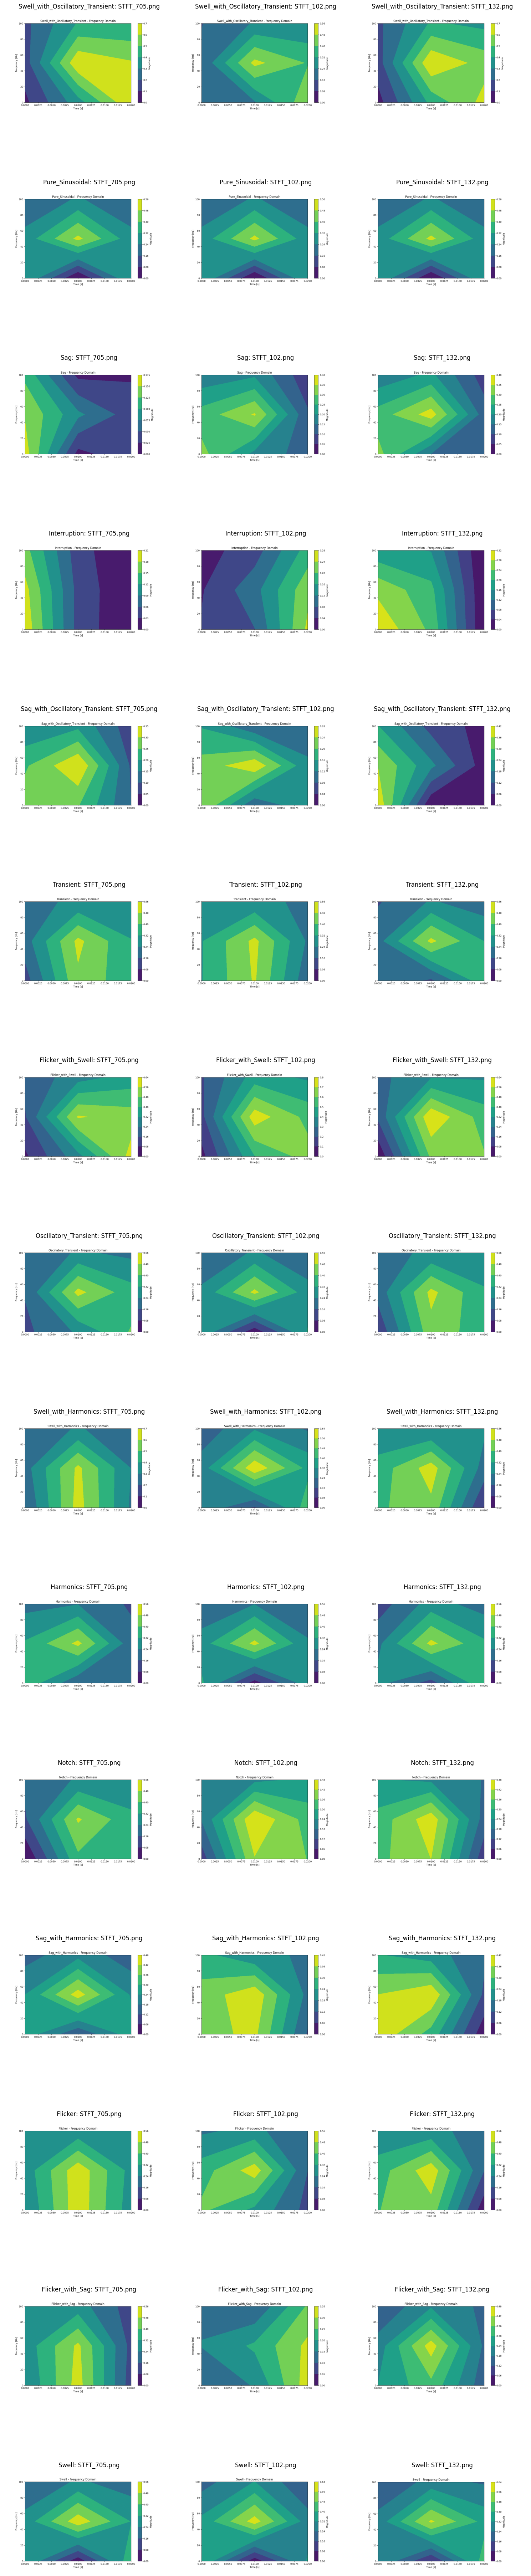

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the base directory
base_dir = '/kaggle/input/'

# Get the disturbance classes
disturbance_classes = os.listdir(base_dir)

# Plot 3 images per class
fig, axes = plt.subplots(len(disturbance_classes), 3, figsize=(15, 5 * len(disturbance_classes)))

for i, disturbance in enumerate(disturbance_classes):
    # Get the folder path and images
    folder_path = os.path.join(base_dir, disturbance)
    images = os.listdir(folder_path)[:3]  # Take the first 3 images

    for j, img_name in enumerate(images):
        # Load the image
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        # Plot the image
        ax = axes[i, j] if len(disturbance_classes) > 1 else axes[j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{disturbance}: {img_name}")

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
for disturbance in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, disturbance)
    images = os.listdir(folder_path)

    # Split into train, validation, and test (70%, 10%, 10%)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy files to respective directories
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(output_dir, 'train', disturbance, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(output_dir, 'valid', disturbance, image))
    for image in test_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(output_dir, 'test', disturbance, image))


In [6]:
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(output_dir, split)
    print(f"{split.capitalize()} set:")
    for disturbance in os.listdir(split_dir):
        print(f"  {disturbance}: {len(os.listdir(os.path.join(split_dir, disturbance)))} images")


Train set:
  Notch: 700 images
  Swell_with_Oscillatory_Transient: 700 images
  Oscillatory_Transient: 700 images
  Flicker_with_Sag: 700 images
  Transient: 700 images
  Sag_with_Harmonics: 700 images
  Swell: 700 images
  Sag_with_Oscillatory_Transient: 700 images
  Pure_Sinusoidal: 700 images
  Harmonics: 700 images
  Flicker: 700 images
  Interruption: 700 images
  Swell_with_Harmonics: 700 images
  Flicker_with_Swell: 700 images
  Sag: 700 images
Valid set:
  Notch: 150 images
  Swell_with_Oscillatory_Transient: 150 images
  Oscillatory_Transient: 150 images
  Flicker_with_Sag: 150 images
  Transient: 150 images
  Sag_with_Harmonics: 150 images
  Swell: 150 images
  Sag_with_Oscillatory_Transient: 150 images
  Pure_Sinusoidal: 150 images
  Harmonics: 150 images
  Flicker: 150 images
  Interruption: 150 images
  Swell_with_Harmonics: 150 images
  Flicker_with_Swell: 150 images
  Sag: 150 images
Test set:
  Notch: 150 images
  Swell_with_Oscillatory_Transient: 150 images
  Oscillato

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1,  # Reduced height shift
    zoom_range=0.1,  # Reduced zoom
    
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',  # Correct path for training data
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/valid',  # Correct path for validation data
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffling
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/test',  # Correct path for test data
    target_size=(128, 128),
    batch_size=32,  class_mode='categorical',
    shuffle=False  # Disable shuffling
)

Found 10500 images belonging to 15 classes.
Found 2250 images belonging to 15 classes.
Found 2250 images belonging to 15 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv2D, MaxPooling2D, Flatten
from keras.layers import Activation
# Define CNN-LSTM Hybrid Model
model = Sequential([
    # CNN Feature Extractor
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    # Flatten to prepare for LSTM
    Flatten(),  

    # Fully Connected layer before LSTM
    Dense(512, activation='relu'),  
    Dropout(0.3),

    # Reshape for LSTM Input (Adjust dynamically based on feature size)
    tf.keras.layers.Reshape((-1, 32)),  # Let TensorFlow determine the first dimension
  # 16 time-steps, 32 features per step

    # First BiLSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Activation('tanh'),
    Dropout(0.2),

    # Second BiLSTM layer
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Activation('tanh'),
    Dropout(0.2),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),

    # Output Layer (15 classes)
    Dense(15, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 16, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 67,541,519 (257.65 MB)

 Trainable params: 67,540,751 (257.65 MB)

 Non-trainable params: 768 (3.00 KB)

None


In [9]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop training after 5 epochs of no improvement
    restore_best_weights=True,  # Restore best model weights
    verbose=1
)
# Learning rate scheduler to adjust learning rate dynamically
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,             
    patience=3,             
    min_lr=1e-6,           
    verbose=1              
)

In [10]:
# Train the model with both callbacks
r = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50, callbacks=[ lr_scheduler ,early_stop]                  
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.0698 - loss: 2.8083 - val_accuracy: 0.0942 - val_loss: 2.6751 - learning_rate: 1.0000e-04
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.2430 - loss: 2.3294 - val_accuracy: 0.3129 - val_loss: 1.9159 - learning_rate: 1.0000e-04
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.3162 - loss: 1.9462 - val_accuracy: 0.3956 - val_loss: 1.6268 - learning_rate: 1.0000e-04
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.3574 - loss: 1.7708 - val_accuracy: 0.4653 - val_loss: 1.4554 - learning_rate: 1.0000e-04
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.3877 - loss: 1.6500 - val_accuracy: 0.4693 - val_loss: 1.4348 - learning_rate: 1.0000e-04
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.4189 - loss: 1.5669 - val_accuracy: 0.2911 - val_loss: 1.9344 - learning_rate: 1.0000e-04
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.44

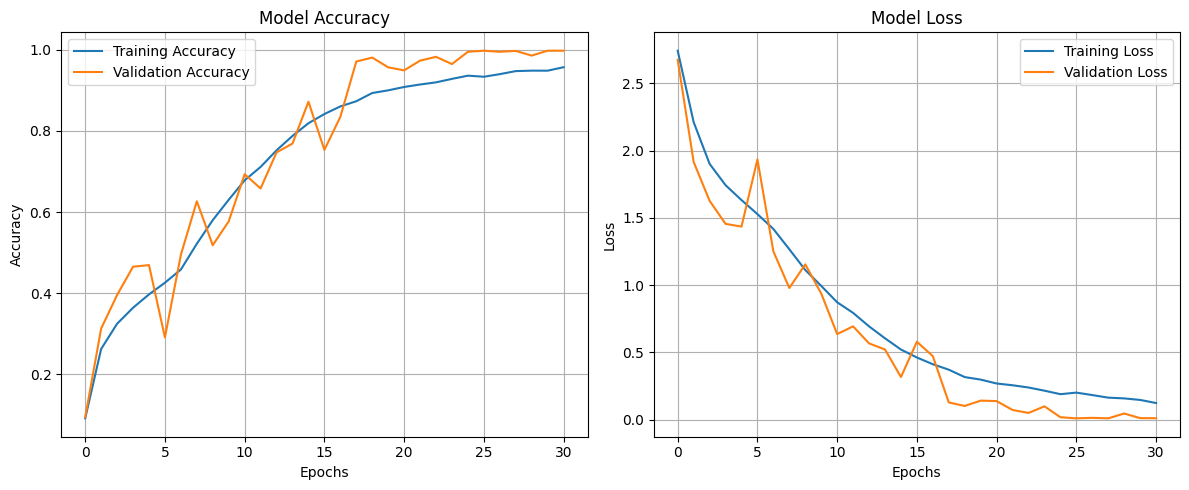

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [12]:
 # Predict on validation data
Y_pred_val = model.predict(val_generator, 
                           steps=int(np.ceil(val_generator.samples / val_generator.batch_size)), 
                           verbose=1)

# Convert predicted probabilities to class indices
y_pred_val = np.argmax(Y_pred_val, axis=1)

# Extract true labels
true_labels = val_generator.classes  # These are the ground truth labels
predicted_labels = y_pred_val  # These are your model's predictions

# Calculate accuracy
from sklearn.metrics import accuracy_score
validation_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step
Validation Accuracy: 0.9978


71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step


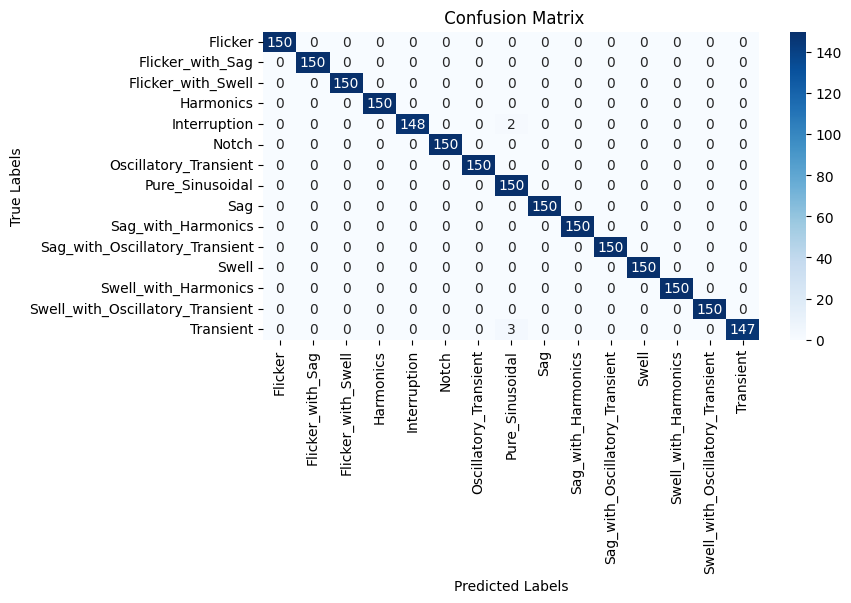


 Classification Report:
                                  precision    recall  f1-score   support

                         Flicker       1.00      1.00      1.00       150
                Flicker_with_Sag       1.00      1.00      1.00       150
              Flicker_with_Swell       1.00      1.00      1.00       150
                       Harmonics       1.00      1.00      1.00       150
                    Interruption       1.00      0.99      0.99       150
                           Notch       1.00      1.00      1.00       150
           Oscillatory_Transient       1.00      1.00      1.00       150
                 Pure_Sinusoidal       0.97      1.00      0.98       150
                             Sag       1.00      1.00      1.00       150
              Sag_with_Harmonics       1.00      1.00      1.00       150
  Sag_with_Oscillatory_Transient       1.00      1.00      1.00       150
                           Swell       1.00      1.00      1.00       150
            

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the validation data
val_predictions = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes  # True labels from the validation generator
val_class_names = list(val_generator.class_indices.keys())  # Get class names from the generator

# Compute the confusion matrix for validation data
val_cm = confusion_matrix(val_true_labels, val_predicted_labels)

# Create a heatmap for validation data
plt.figure(figsize=(8, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.title(' Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report for validation data
print("\n Classification Report:")
print(classification_report(val_true_labels, val_predicted_labels, target_names=val_class_names))


In [14]:
# Predict on test data
Y_pred_test = model.predict(test_generator, 
                            steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), 
                            verbose=1)
y_pred_test = np.argmax(Y_pred_test, axis=1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 623ms/step


In [15]:
from sklearn.metrics import accuracy_score

# Assuming y_true are the true class labels for your validation/test set
accuracy = accuracy_score(test_generator.classes,y_pred_test)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9973333333333333


In [16]:
# Save the model in HDF5 format
model.save('pqd_cnn_model1.h5')


In [17]:
from keras.models import load_model

# Load the saved model
model = load_model('pqd_cnn_model1.h5')


In [18]:
import os
import random
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the test dataset
test_dir = '/kaggle/working/test'

# Collect all image paths
all_image_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(test_dir)
                   for file in files if file.endswith(('jpg', 'png', 'jpeg'))]

# Select 10 random images
random_image_paths = random.sample(all_image_paths, min(10, len(all_image_paths)))

# Get class labels from test generator
class_labels = list(test_generator.class_indices.keys())

# Test and print results for 10 random images
for i, img_path in enumerate(random_image_paths, 1):
    true_label = os.path.basename(os.path.dirname(img_path))
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)  # Normalize and add batch dim
    predicted_class = class_labels[np.argmax(model.predict(img_array))]
    print(f"Image {i}: True Label: {true_label}, Predicted Label: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Image 1: True Label: Sag, Predicted Label: Sag
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 2: True Label: Flicker_with_Swell, Predicted Label: Flicker_with_Swell
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image 3: True Label: Flicker_with_Sag, Predicted Label: Flicker_with_Sag
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 4: True Label: Harmonics, Predicted Label: Harmonics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image 5: True Label: Swell_with_Harmonics, Predicted Label: Swell_with_Harmonics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 6: True Label: Transient, Predicted Label: Transient
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 7: True Label: Sag_with_Harmonics, Predicted Label: Sag_with_Harmonics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image 8: True Label: Swell_with_Harmonics, Predicted Label: Swell_with_Harmonics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image 9: True Label: Harmonics, Predicted Label: Harmonics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


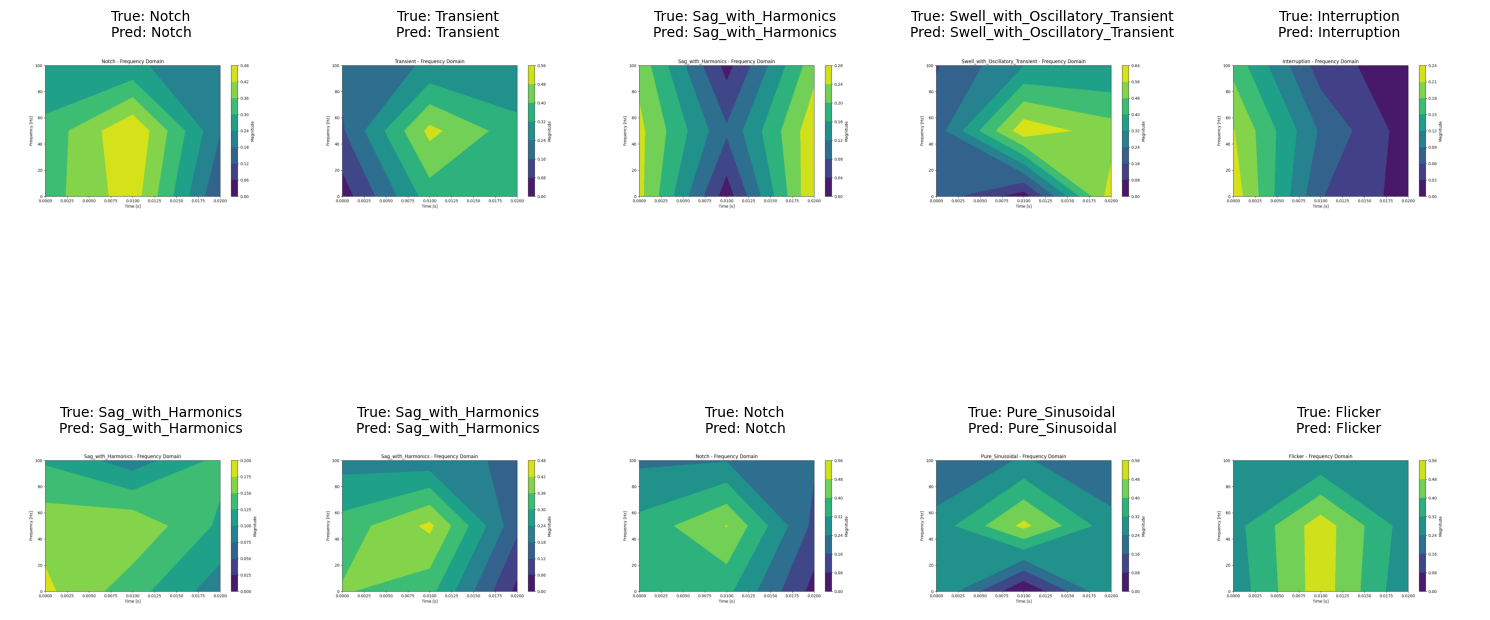

In [19]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the test dataset
test_dir = '/kaggle/working/test'

# Collect all image paths
all_image_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(test_dir)
                   for file in files if file.endswith(('jpg', 'png', 'jpeg'))]

# Select 10 random images
random_image_paths = random.sample(all_image_paths, min(10, len(all_image_paths)))

# Get class labels from test generator
class_labels = list(test_generator.class_indices.keys())

# Plot images with true and predicted labels
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(random_image_paths, 1):
    true_label = os.path.basename(os.path.dirname(img_path))
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)  # Normalize and add batch dim
    predicted_class = class_labels[np.argmax(model.predict(img_array))]
    
    # Plot image
    plt.subplot(2, 5, i)
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {predicted_class}", fontsize=10)

plt.tight_layout()
plt.show()


71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step


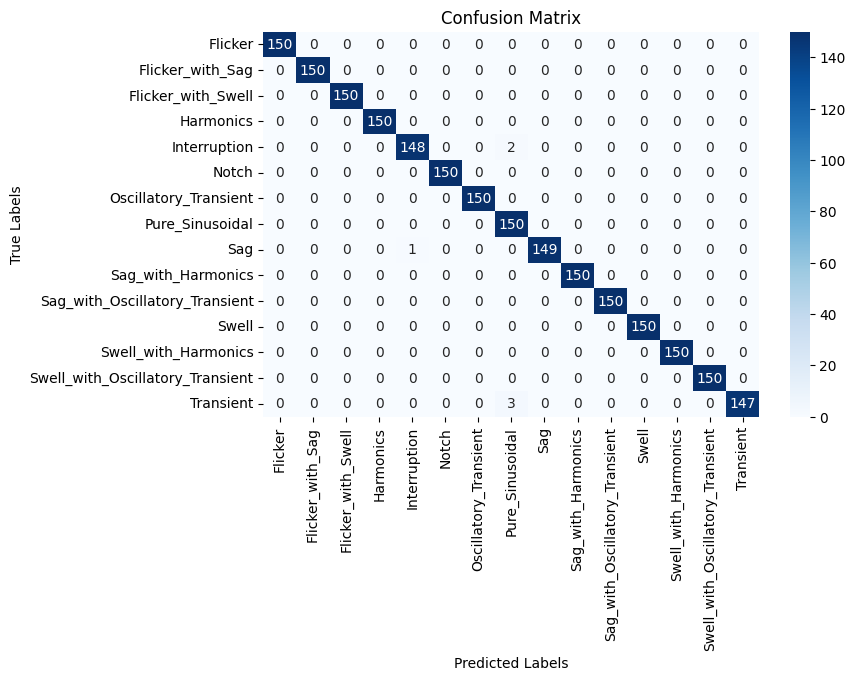


Classification Report:
                                  precision    recall  f1-score   support

                         Flicker       1.00      1.00      1.00       150
                Flicker_with_Sag       1.00      1.00      1.00       150
              Flicker_with_Swell       1.00      1.00      1.00       150
                       Harmonics       1.00      1.00      1.00       150
                    Interruption       0.99      0.99      0.99       150
                           Notch       1.00      1.00      1.00       150
           Oscillatory_Transient       1.00      1.00      1.00       150
                 Pure_Sinusoidal       0.97      1.00      0.98       150
                             Sag       1.00      0.99      1.00       150
              Sag_with_Harmonics       1.00      1.00      1.00       150
  Sag_with_Oscillatory_Transient       1.00      1.00      1.00       150
                           Swell       1.00      1.00      1.00       150
            S

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes  # True labels from the test generator
class_names = list(test_generator.class_indices.keys())  # Get class names from the generator

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
